In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics, optimizers, callbacks
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from imblearn.metrics import classification_report_imbalanced

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [2]:
df = (
    pd.read_csv("./DryBeanDataset/Dry_Bean_Dataset.csv")
    .sample(frac=1)
    .reset_index(drop=True)
)
# df = pd.read_csv("./selected_features/Anova.csv")

In [3]:
df.head(10)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,67311,1037.096,374.417253,229.301248,1.632862,0.790531,68197,292.750793,0.756907,0.987008,0.786426,0.781884,0.005562,0.001282,0.611342,0.998238,BARBUNYA
1,72263,1097.796,375.594915,245.380765,1.530662,0.757089,73699,303.328385,0.719393,0.980515,0.753499,0.807594,0.005198,0.001364,0.652209,0.998311,BARBUNYA
2,38858,753.174,280.915962,176.562975,1.591024,0.777789,39287,222.430983,0.690809,0.989080,0.860795,0.791806,0.007229,0.001753,0.626957,0.997504,SIRA
3,42412,752.034,246.964873,218.819383,1.128624,0.463619,42848,232.380368,0.771436,0.989824,0.942375,0.940945,0.005823,0.002816,0.885378,0.999259,SEKER
4,34366,672.823,242.708301,181.042190,1.340617,0.666030,34666,209.179708,0.758497,0.991346,0.953975,0.861856,0.007062,0.002404,0.742796,0.995806,DERMASON
5,24469,578.395,217.572673,143.446059,1.516756,0.751878,24762,176.507502,0.706666,0.988167,0.919130,0.811258,0.008892,0.002376,0.658139,0.998236,DERMASON
6,40547,725.149,259.024364,199.592115,1.297769,0.637375,40819,227.213652,0.761990,0.993336,0.968978,0.877190,0.006388,0.002333,0.769463,0.998585,SEKER
7,165330,1540.253,574.535399,368.862049,1.557589,0.766690,167922,458.807905,0.776744,0.984564,0.875744,0.798572,0.003475,0.000872,0.637717,0.993301,BOMBAY
8,176826,1632.597,640.290869,354.942649,1.803928,0.832286,179666,474.491154,0.809576,0.984193,0.833677,0.741056,0.003621,0.000674,0.549163,0.990651,BOMBAY
9,78930,1079.255,417.604550,242.072082,1.725125,0.814853,79874,317.012298,0.784483,0.988181,0.851538,0.759121,0.005291,0.001084,0.576264,0.994128,CALI


In [4]:
net = tf.keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(7),
    ]
)

In [6]:
X = df.drop(columns=["Class"]).values
# y = df.Class.astype("category").cat.codes.values
y = df.Class.astype('category').cat.codes.values

In [30]:
# X, y = SMOTE().fit_resample(X, y)

In [7]:
# scaling the the data for training!
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train = scaler.fit_transform(X_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

In [9]:
net.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

In [10]:
history = net.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        callbacks.ModelCheckpoint("models/4", save_best_only=True, verbose=3),
    ],
)

Epoch 1/20
230/240 [===========================>..] - ETA: 0s - loss: 0.4989 - sparse_categorical_accuracy: 0.8459
Epoch 00001: val_loss improved from inf to 0.27054, saving model to models\4
INFO:tensorflow:Assets written to: models\4\assets
240/240 [==============================] - 3s 8ms/step - loss: 0.4904 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.2705 - val_sparse_categorical_accuracy: 0.9091
Epoch 2/20
229/240 [===========================>..] - ETA: 0s - loss: 0.2237 - sparse_categorical_accuracy: 0.9207
Epoch 00002: val_loss improved from 0.27054 to 0.23979, saving model to models\4
INFO:tensorflow:Assets written to: models\4\assets
240/240 [==============================] - 2s 8ms/step - loss: 0.2241 - sparse_categorical_accuracy: 0.9212 - val_loss: 0.2398 - val_sparse_categorical_accuracy: 0.9150
Epoch 3/20
230/240 [===========================>..] - ETA: 0s - loss: 0.2036 - sparse_categorical_accuracy: 0.9254
Epoch 00003: val_loss improved from 0.23979 to 0.23105, s

In [11]:
# Transforming the test set

X_test = scaler.transform(X_test)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

In [12]:
net.evaluate(test_ds)

213/213 [==============================] - 1s 2ms/step - loss: 0.1904 - sparse_categorical_accuracy: 0.9289


[0.19042223691940308, 0.9288862943649292]

In [13]:
preds = net(X_test)
preds = tf.argmax(preds, axis=1)

In [15]:
cf = confusion_matrix(y_test, preds)

classes = df.Class.astype("category").cat.categories.tolist()
print(classification_report_imbalanced(y_test, preds, target_names=classes))

                   pre       rec       spe        f1       geo       iba       sup

   BARBUNYA       0.95      0.96      0.99      0.96      0.98      0.95       335
     BOMBAY       1.00      1.00      1.00      1.00      1.00      1.00       150
       CALI       0.96      0.96      0.99      0.96      0.97      0.95       386
   DERMASON       0.92      0.91      0.97      0.91      0.94      0.88       893
      HOROZ       0.96      0.96      0.99      0.96      0.98      0.95       458
      SEKER       0.96      0.95      0.99      0.96      0.97      0.94       512
       SIRA       0.85      0.88      0.96      0.86      0.92      0.84       669

avg / total       0.93      0.93      0.98      0.93      0.96      0.91      3403



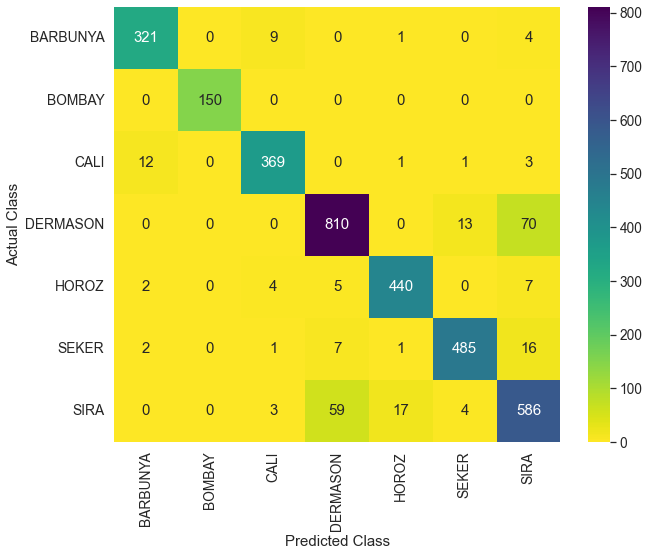

In [17]:
classes = df.Class.astype("category").cat.categories.tolist()
sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)
ax = sns.heatmap(
    cf, annot=True, xticklabels=classes, yticklabels=classes, fmt="d", cmap="viridis_r"
)
ax.set_ylabel("Actual Class")
_ = ax.set_xlabel("Predicted Class")

## Testing on one example

In [22]:
sample = X_test[10]
sample, y_test[10]

(array([-0.62180646, -0.76679377, -0.65111294, -0.75483974, -0.05892578,
         0.21357593, -0.62665287, -0.71639006,  1.29420515,  0.95441196,
         0.73853368, -0.0397688 ,  0.89863268,  0.28491842, -0.07818509,
         0.5787687 ]),
 3)

In [23]:
X_test_scaled = scaler.transform(X_test)

In [29]:
scaler.mean_, scaler.scale_

(array([5.28806800e+04, 8.54464248e+02, 3.19966306e+02, 2.01985776e+02,
        1.58443882e+00, 7.51143776e-01, 5.35969176e+04, 2.52814512e+02,
        7.49406799e-01, 9.87152868e-01, 8.73169414e-01, 7.99611972e-01,
        6.56701964e-03, 1.71557757e-03, 6.43212375e-01, 9.95071891e-01]),
 array([2.88348244e+04, 2.11791300e+02, 8.49818004e+01, 4.42656713e+01,
        2.47544422e-01, 9.23221967e-02, 2.92776408e+04, 5.84345382e+01,
        4.90807704e-02, 4.57335251e-03, 5.93698993e-02, 6.19117901e-02,
        1.11785313e-03, 5.97888436e-04, 9.93098433e-02, 4.29739483e-03]))

In [30]:
import joblib

In [31]:
joblib.dump(scaler, filename="./ML_models/NN_scaler.scaler")

['./ML_models/NN_scaler.scaler']

In [24]:
def predict(feats):
    idx2class = {
        0: "BARBUNYA",
        1: "BOMBAY",
        2: "CALI",
        3: "DERMASON",
        4: "HOROZ",
        5: "SEKER",
        6: "SIRA",
    }

    payload = {"instances": [feats.tolist()]}

    res = requests.post(
        url="http://localhost:8605/v1/models/dry_bean_model:predict", json=payload
    )

    preds = res.json()
    preds = preds["predictions"]
    idx = tf.argmax(preds, axis=1)

    print(f"The predicted class is: {idx2class[idx.numpy()[0]]}")

In [25]:
predict(X_test_scaled[10])

The predicted class is: DERMASON


In [33]:
X_test_scaled[0].shape

(16,)